In [1]:
# import packages
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import os
import cv2 
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

In [2]:
# training data filepaths 

all_0 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_0/all"
hem_0 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_0/hem"

all_1 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_1/all"
hem_1 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_1/hem"
all_2 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_2/all"
hem_2 = os.getcwd() + "/C-NMC_Leukemia/training_data/fold_2/hem"

print(all_0)

/Users/isaacbilsel/Documents/GW_Projects/ML/CSCI-4364-Final-Project/C-NMC_Leukemia/training_data/fold_0/all


In [3]:
# get the path of the valiation data (images and csv file)

# image file folder path
val_path = os.getcwd() + "/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"

# csv file path
val_labels_path = os.getcwd() + "/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv"

# read the csv file
val_labels = pd.read_csv(val_labels_path)
val_labels.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [4]:
# function to store image paths in a list
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder) 
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)
    
    return image_paths

In [5]:
# Merge the image file and csv file into one dataset

# get the list of the validation image paths
val_image = get_path_image(val_path) 

# get the list of the names of the images (image id)
image_name = os.listdir(val_path) 

# create a dataframe from the image paths and the image name (image id)
val_df = pd.DataFrame({'img_data': val_image, 'new_names': image_name})

# merge the image data and the csv data into one file using the unique image_id (image_id is called new_names, column name)
val_df = pd.merge(val_df, val_labels, on='new_names', how='inner')

val_df.head() # validation dataset

,img_data,new_names,Patient_ID,labels
0,/Users/isaacbilsel/Documents/GW_Projects/ML/CS...,735.bmp,UID_H25_9_1_hem.bmp,0
1,/Users/isaacbilsel/Documents/GW_Projects/ML/CS...,721.bmp,UID_H49_13_1_hem.bmp,0
2,/Users/isaacbilsel/Documents/GW_Projects/ML/CS...,709.bmp,UID_65_22_5_all.bmp,1
3,/Users/isaacbilsel/Documents/GW_Projects/ML/CS...,1289.bmp,UID_57_33_2_all.bmp,1
4,/Users/isaacbilsel/Documents/GW_Projects/ML/CS...,1262.bmp,UID_H39_24_2_hem.bmp,0


In [7]:
print(val_df.iloc[0,0])

/Users/zhaoyangchen/Desktop/ML_Project/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/735.bmp


In [6]:
# combine folders into one set of data
img_data = []

# we use the data from folder 0 for now
for i in [all_0, all_1, all_2, hem_0, hem_1, hem_2]:
    paths = get_path_image(i)
    img_data.extend(paths)
    
print(len(img_data)) # number of training data


10661


In [7]:
# create dataframe of the training data, with labels

data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

df = pd.DataFrame(data) 

''' 
# For just the first folder
df["labels"][0:2397] = 1 # ALL
df["labels"][2397:3527] = 0 # HEM
'''

# For all three folders
df["labels"][0:7272] = 1 # ALL
df["labels"][7272:10661] = 0 # HEM

df["labels"] = df["labels"].astype("int64")

/var/folders/f6/mcxlkrd15h37z4kj8l7n7dcw0000gn/T/ipykernel_29257/1900656078.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"][0:7272] = 1 # ALL
/var/folders/f6/mcxlkrd15h37z4kj8l7n7dcw0000gn/T/ipykernel_29257/1900656078.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"][7272:10661] = 0 # HEM


In [8]:
df.head()

,img_data,labels
0,/Users/isaacbilsel/Documents/GW_Projects/ML/CS...,1
1,/Users/isaacbilsel/Documents/GW_Projects/ML/CS...,1
2,/Users/isaacbilsel/Documents/GW_Projects/ML/CS...,1
3,/Users/isaacbilsel/Documents/GW_Projects/ML/CS...,1
4,/Users/isaacbilsel/Documents/GW_Projects/ML/CS...,1


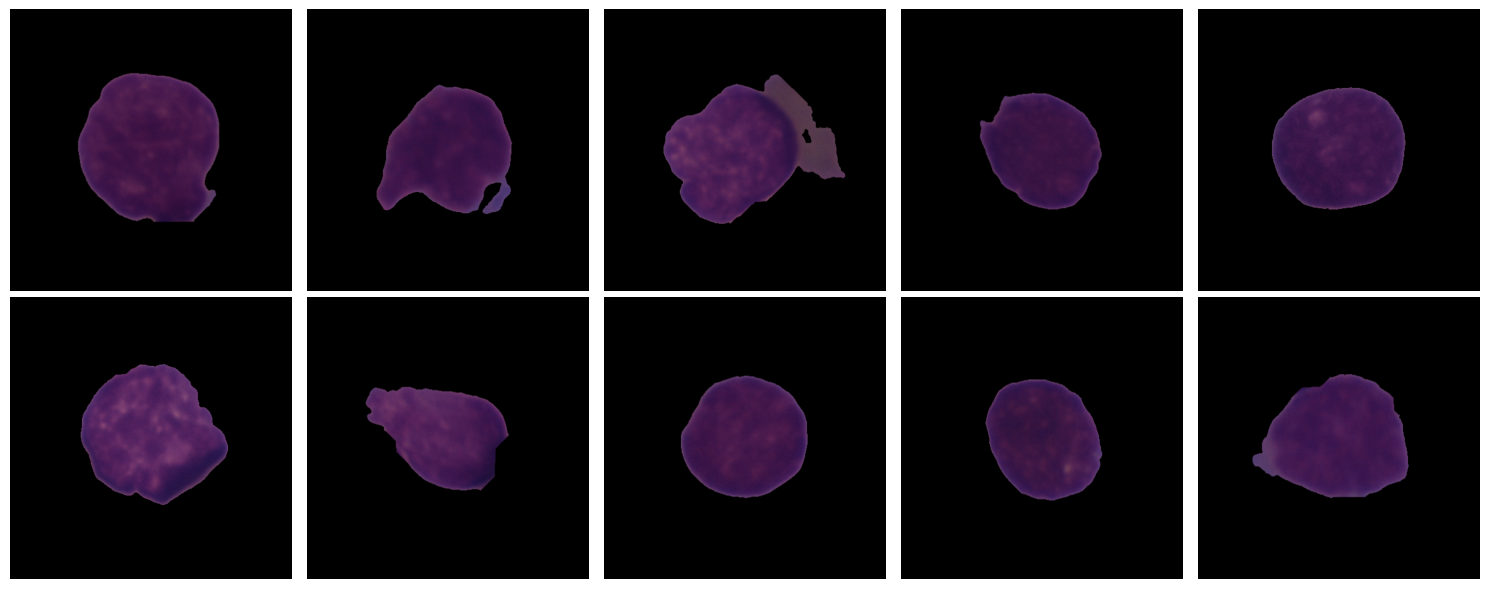

In [9]:
# some images of the cells (cancer cell vs healthy cell)
import matplotlib.image as mpimg
first_10_images = df['img_data'].head(10)

# first 10 images of the cancer cell
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, image_path in enumerate(first_10_images):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

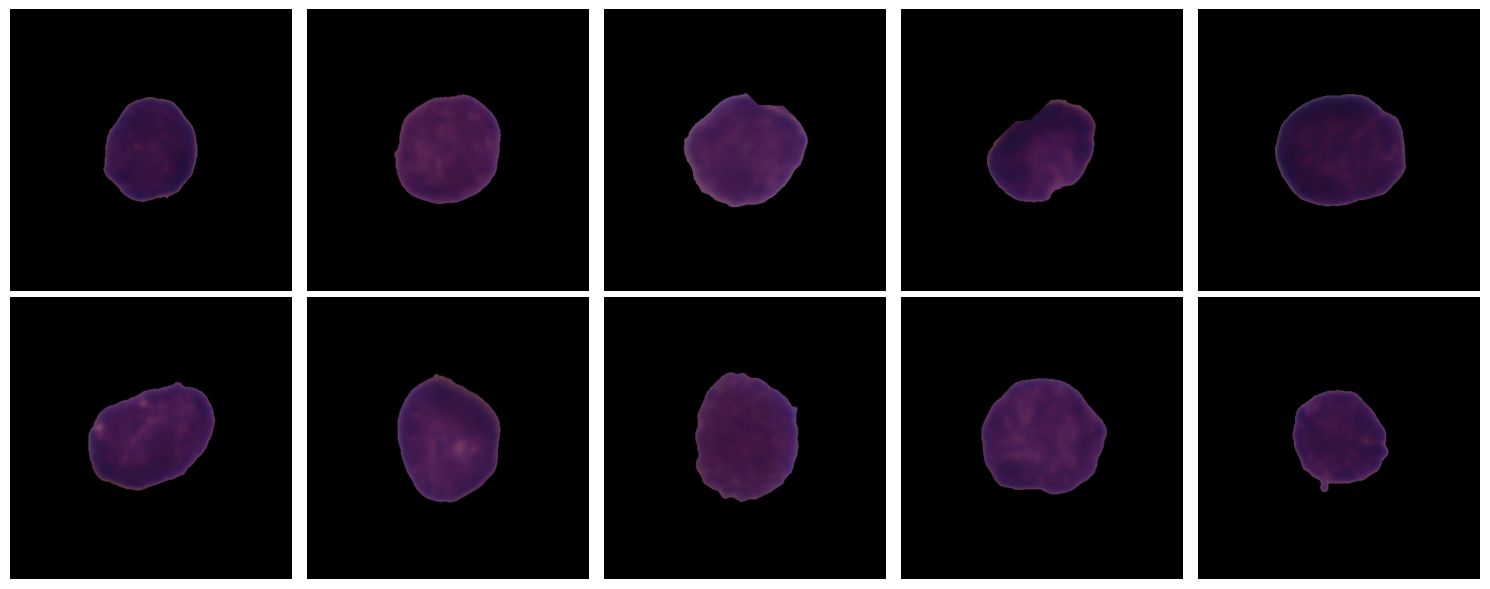

In [44]:
# first 10 images of the healthy cell
starting_row = 1131
first_10_images = df['img_data'].iloc[starting_row:starting_row+10]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, image_path in enumerate(first_10_images):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

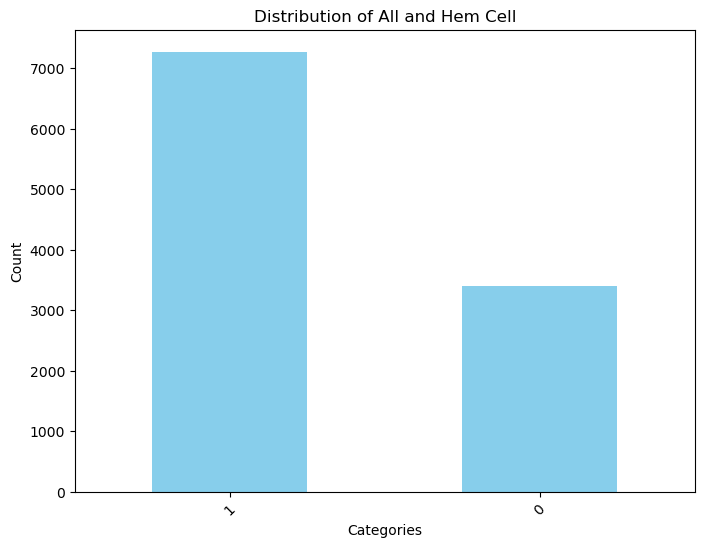

In [10]:
# check if the dataset is balanced or not

target_counts = df["labels"].value_counts()
# create a bar plot
plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of All and Hem Cell')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [19]:
'''
# since the size of dataset is large enough, we will use undersampling to handle the imbalanced datasets
print(target_counts)
df = df[1267:]
print(df["labels"].value_counts())
'''

labels
1    2397
0    1130
Name: count, dtype: int64
labels
1    1130
0    1130
Name: count, dtype: int64


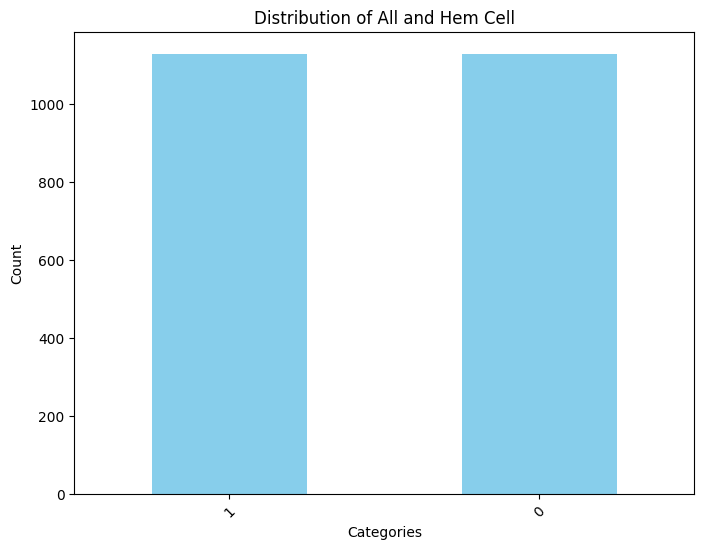

In [20]:
'''
# the dataset is balanced now (contains 1130 of each category)
plt.figure(figsize=(8, 6))
target_counts = df["labels"].value_counts()
target_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of All and Hem Cell')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
'''

In [21]:
# function to convert the dataframe into image and label, as input for the model

def load_and_preprocess_images(df, target_size=(224, 224)):
    images = []
    labels = []

    for index, row in df.iterrows():
        # load image using OpenCV
        image = cv2.imread(row['img_data'])
        # resize image to target size
        image = cv2.resize(image, target_size)
        # normalize pixel values
        image = image.astype('float32') / 255.0
        images.append(image)
        labels.append(row['labels'])

    return np.array(images), np.array(labels)

In [22]:
# build the VGG19 model 
def build_vgg19_model(input_shape, num_classes):
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(vgg19)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False
    return model

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [25]:
# data preparation (training images and labels)
train_images, train_labels = load_and_preprocess_images(df)

# data preparation (validation images and labels)
validation_images, validation_labels = load_and_preprocess_images(val_df)

# define input shape
input_shape = (224, 224, 3)

# define number of classes
num_classes = 2

# build model
model = build_vgg19_model(input_shape, num_classes)

# compile model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train model
history = model.fit(train_images, train_labels, epochs=8, batch_size=64, validation_data=(validation_images, validation_labels))

# evaluate model
loss, accuracy = model.evaluate(validation_images, validation_labels)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# Plot training statistics
plot_training(history)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 526s 7s/step - accuracy: 0.5937 - loss: 3.1221 - val_accuracy: 0.6288 - val_loss: 0.6689
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 547s 8s/step - accuracy: 0.7631 - loss: 0.5112 - val_accuracy: 0.6765 - val_loss: 0.6406
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 559s 8s/step - accuracy: 0.7774 - loss: 0.4945 - val_accuracy: 0.6615 - val_loss: 0.6451
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 563s 8s/step - accuracy: 0.7651 - loss: 0.5011 - val_accuracy: 0.6529 - val_loss: 0.6473
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 566s 8s/step - accuracy: 0.7572 - loss: 0.5182 - val_accuracy: 0.6818 - val_loss: 0.6658
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 571s 8s/step - accuracy: 0.7956 - loss: 0.4854 - val_accuracy: 0.6733 - val_loss: 0.6327
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 574s 8s/step - accuracy: 0.7401 - loss: 0.5169 - val_accuracy: 0.6674 - val_loss: 0.6389
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 675s 10s/step - accuracy: 0.7674 - loss: 0.5107 - val_accuracy: 0.6535 - 